<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Higgs_Boson_QMAML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Download and unzip the Higgs dataset, install dependencies
!wget -O HIGGS.csv.gz https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gunzip HIGGS.csv.gz
!pip install pennylane --quiet

--2025-06-11 13:19:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [            <=>     ]   2.62G  79.4MB/s    in 46s     

2025-06-11 13:20:33 (57.9 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [34]:
CSV_PATH = 'HIGGS.csv'
#N_TRAIN = 10000         # Use a small subset for quantum simulation speed!
#N_TEST = 2000
N_FEATURES = 8          # We'll use 8 features for speed (can be more)
N_CLASSES = 2

# PQC/QNN
N_QUBITS = 4
#PQC_LAYERS = 2

# Meta-initializer MLP
META_INIT_HIDDEN = 64

# Training
#BATCH_SIZE = 32
#N_EPOCHS = 5
LR = 0.01

N_TRAIN = 500
N_TEST = 100
N_EPOCHS = 2
PQC_LAYERS = 1
BATCH_SIZE = 16

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import pennylane as qml
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt

In [36]:
# 3. Dataset (use only first N_FEATURES for quantum speed)
class HiggsDataset(Dataset):
    def __init__(self, csv_path, n_samples=None, offset=0):
        df = pd.read_csv(csv_path, header=None, nrows=n_samples, skiprows=range(1, offset+1))
        X = df.iloc[:, 1:].values.astype(np.float32)[:, :N_FEATURES]
        self.X = X
        self.y = df.iloc[:, 0].values.astype(np.int64)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]

In [37]:
# 4. Task embedding and meta-initializer MLP
def task_embedding(task_id, n_qubits=N_QUBITS):
    # Simple: one-hot or random vector for each task
    emb = torch.zeros(n_qubits)
    emb[task_id % n_qubits] = 1.0
    return emb

class MetaInitializerMLP(nn.Module):
    def __init__(self, emb_dim, pqc_layers, n_qubits):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, META_INIT_HIDDEN),
            nn.ReLU(),
            nn.Linear(META_INIT_HIDDEN, pqc_layers * n_qubits * 2)
        )
        self.pqc_layers = pqc_layers
        self.n_qubits = n_qubits
    def forward(self, emb):
        out = self.mlp(emb)
        return out.view(self.pqc_layers, self.n_qubits, 2)

In [38]:
# 5. PQC/QNN classifier
dev = qml.device("default.qubit", wires=N_QUBITS)

def angle_encode(x):
    for i in range(N_QUBITS):
        qml.RY(x[i], wires=i)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def pqc_classifier(weights, x):
    angle_encode(x)
    for l in range(weights.shape[0]):
        for i in range(N_QUBITS):
            qml.RY(weights[l, i, 0], wires=i)
            qml.RZ(weights[l, i, 1], wires=i)
        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))  # Use qubit 0 for binary classification

In [39]:
def train_meta_qnn(train_dataset, n_epochs, batch_size, device):
    meta_init = MetaInitializerMLP(N_QUBITS, PQC_LAYERS, N_QUBITS).to(device)
    optimizer = optim.Adam(meta_init.parameters(), lr=LR)
    losses, accs, f1s, rocs = [], [], [], []
    for epoch in range(n_epochs):
        meta_init.train()
        total_loss = 0
        all_preds, all_trues = [], []
        for i in range(0, len(train_dataset), batch_size):
            X_batch = torch.stack([train_dataset[j][0] for j in range(i, min(i+batch_size, len(train_dataset)))])
            y_batch = torch.tensor([train_dataset[j][1] for j in range(i, min(i+batch_size, len(train_dataset)))])
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            emb = task_embedding(0).to(device)
            pqc_params = meta_init(emb)
            preds = torch.stack([pqc_classifier(pqc_params, x) for x in X_batch])
            preds = preds.float()
            preds = (preds + 1) / 2
            y_batch = y_batch.float()
            loss = nn.BCELoss()(preds, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(y_batch.cpu().numpy())
        avg_loss = total_loss / len(train_dataset)
        pred_labels = (np.array(all_preds) > 0.5).astype(int)
        acc = accuracy_score(all_trues, pred_labels)
        f1 = f1_score(all_trues, pred_labels)
        try:
            roc = roc_auc_score(all_trues, all_preds)
        except:
            roc = float('nan')
        losses.append(avg_loss)
        accs.append(acc)
        f1s.append(f1)
        rocs.append(roc)
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}, Acc {acc:.4f}, F1 {f1:.4f}, ROC-AUC {roc:.4f}")
    return meta_init, losses, accs, f1s, rocs

In [40]:
def eval_meta_qnn(meta_init, test_dataset, device):
    meta_init.eval()
    emb = task_embedding(0).to(device)
    pqc_params = meta_init(emb)
    preds, trues = [], []
    for i in range(len(test_dataset)):
        x, y = test_dataset[i]
        x = x.to(device)
        pred = pqc_classifier(pqc_params, x)
        pred = (pred.item() + 1) / 2
        preds.append(pred)
        trues.append(y)
    preds = np.array(preds)
    trues = np.array(trues)
    pred_labels = (preds > 0.5).astype(int)
    acc = accuracy_score(trues, pred_labels)
    f1 = f1_score(trues, pred_labels)
    try:
        roc = roc_auc_score(trues, preds)
    except:
        roc = float('nan')
    print(f"Test Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}")
    return preds, trues

cuda
Loading data...
Training meta-initializer + PQC classifier...
Epoch 1: Loss 0.7478, Acc 0.5680, F1 0.6656, ROC-AUC 0.5486
Epoch 2: Loss 0.7607, Acc 0.5740, F1 0.6738, ROC-AUC 0.5407


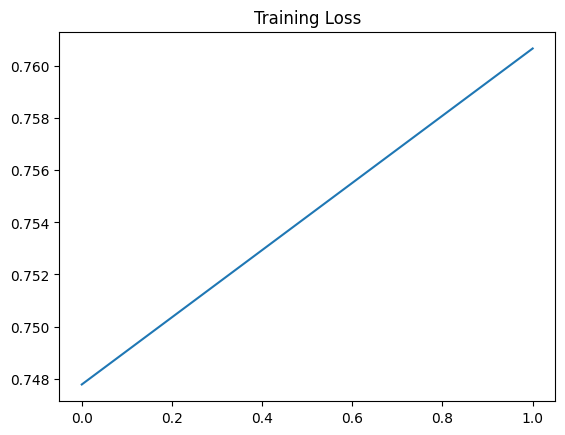

Evaluating...
Test Accuracy: 0.5800, F1: 0.6667, ROC-AUC: 0.5434


(array([0.71048732, 0.72824649, 0.88088958, 0.54799387, 0.6451391 ,
        0.91290903, 0.90399207, 0.56381511, 0.52216484, 0.53458907,
        0.69206141, 0.0995744 , 0.90645782, 0.91860139, 0.58462635,
        0.62894799, 0.89003804, 0.3544767 , 0.18938693, 0.4371481 ,
        0.25559621, 0.72302047, 0.49536134, 0.6564804 , 0.89836739,
        0.41254435, 0.62212795, 0.79500505, 0.85701249, 0.79433974,
        0.8398238 , 0.92152948, 0.55572971, 0.76297916, 0.78170013,
        0.79978627, 0.10982524, 0.55636624, 0.62558537, 0.83113972,
        0.64452604, 0.77562221, 0.83807478, 0.64863778, 0.70440965,
        0.69493014, 0.01472639, 0.8923177 , 0.72914158, 0.50963534,
        0.65813067, 0.60564547, 0.66583524, 0.87754996, 0.70624517,
        0.44587209, 0.49865545, 0.65256426, 0.89356255, 0.43406283,
        0.88553273, 0.51237982, 0.40247287, 0.44960316, 0.66859478,
        0.85152407, 0.62700196, 0.80452511, 0.34958194, 0.81094362,
        0.02692775, 0.08919807, 0.85243393, 0.72

In [42]:
# 8. Run the pipeline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print("Loading data...")
train_dataset = HiggsDataset(CSV_PATH, n_samples=N_TRAIN)
test_dataset = HiggsDataset(CSV_PATH, n_samples=N_TEST, offset=N_TRAIN)
print("Training meta-initializer + PQC classifier...")
meta_init, losses, accs, f1s, rocs = train_meta_qnn(train_dataset, N_EPOCHS, BATCH_SIZE, device)
plt.plot(losses)
plt.title("Training Loss")
plt.show()
print("Evaluating...")
eval_meta_qnn(meta_init, test_dataset, device)

In [ ]:
# After training:
meta_init, losses, accs, f1s, rocs = train_meta_qnn(train_dataset, N_EPOCHS, BATCH_SIZE, device)
plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.plot(losses); plt.title("Loss")
plt.subplot(1,4,2); plt.plot(accs); plt.title("Accuracy")
plt.subplot(1,4,3); plt.plot(f1s); plt.title("F1")
plt.subplot(1,4,4); plt.plot(rocs); plt.title("ROC-AUC")
plt.tight_layout(); plt.show()